In [22]:
### import libraries
import torch
import torch.nn as nn
import numpy as np
import decimal
from decimal import *
from datetime import datetime

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

from google.colab import drive
drive.mount('/content/drive')            #*** MODIFY the path for you local drive****#

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
now = datetime.now()
date_time = now.strftime("%m%d%H%M")
report = "/content/drive/MyDrive/Colab Notebooks/stdout"+date_time+".txt" #*** MODIFY the path for you local drive****#
#sys.stdout = open(report, 'w')

In [24]:
# tanh's linear approximation
def tanh_func(x):
  if x < -384 : y = -128
  elif x > 384 : y = 128
  else : y= x
  return y

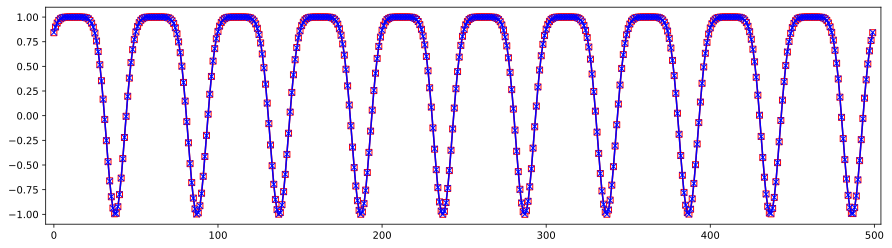

In [25]:
# import the data
N = 500
precision = 128
floatposition = 0  # full precision = 18

# input data = sin(t+cos(t))
time = torch.linspace(0,20*np.pi,N)
data = torch.sin(time+torch.cos(time))

# for storing input data
# data_np = data.numpy()
# np.save('/content/drive/MyDrive/Colab Notebooks/sinewaves',data_np) #*** MODIFY the path for you local drive****#
# data_np

data_fixed = np.float32(data)
data_fixed = np.multiply(np.float32(data_fixed),precision)
data_fixed = np.round(data_fixed,floatposition)
data_fixed_16 = np.int16(data_fixed) # 16 bit integer
data_fixed = torch.tensor(data_fixed) # use for original network verification

plt.figure(figsize=(15,4))
plt.plot(data,'rs-',markerfacecolor='w')
plt.plot(np.multiply(data_fixed_16,1/precision),'bx-',markerfacecolor='r')
plt.xlim([-5,N+4])
plt.show()

In [ ]:
"""
# For verilog testbench

print('data_fixed = ')
for i in range(N):
   print("   write_data(16\'b{});  //{}".format((np.binary_repr(data_fixed_16[i],width=16)), data_fixed_16[i]))
   print("   enable(0);")
   print("   enable(0);")
   print("   enable(0);")
   print("   enable(0);")
   print("   enable(0);")
   print("   enable(0);")
   print("   enable(0);")
   print("   enable(0);")
   print("   out[{}] = yhat_output;".format(i))
print('\n')

"""

In [26]:
# Reference model's network : for performance comparision and parameter extraction

class rnnnet(nn.Module):
  def __init__(self):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self, x, h):
    
    # run through the RNN layer
    y,hidden = self.rnn(x,h)
    
    # and the output (linear) layer
    y = self.out(y)
    
    return y,hidden.detach()

# network parameters
input_size =  1 # "channels" of data
num_hidden =  9 # breadth of model (number of units in hidden layers)
num_layers =  1 # depth of model (number of "stacks" of hidden layers)
seqlength  = 30 # number of datapoints used for learning in each segment
batchsize  =  1 # Note: the training code is actually hard-coded to organize data into batchsize=1

net = rnnnet()
net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/model_weights.pth'))

<All keys matched successfully>

rnnnet(
  (rnn): RNN(1, 9)
  (out): Linear(in_features=9, out_features=1, bias=True)
)


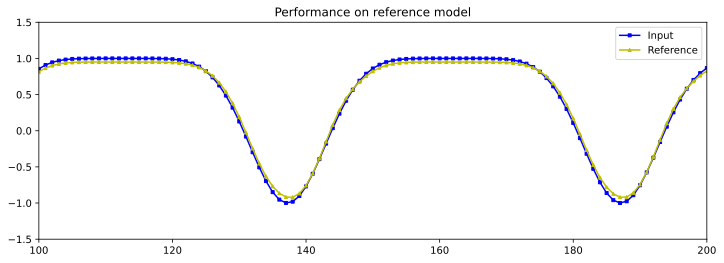

In [29]:
# Loaded network validation

h = np.zeros((N,num_hidden))

yHat = np.zeros(N)
hh = None
for timei in range(N-seqlength):

  # grab a snippet of data
  X = data[timei:timei+seqlength].view(seqlength,1,1)

  # forward pass and loss
  yy,hh = net(X,hh)
  yHat[timei+seqlength] = yy[-1]       # Original prediction result
  h[timei+seqlength,:] = hh.detach()
print(net)

# plotting
fig = plt.figure(figsize=(12,4))
plt.plot(np.multiply(data,1),'bs-',label='Input',markersize=3)
plt.plot(np.multiply(yHat,1),'y^-',label='Reference',markersize=3)
plt.ylim([-1.5,1.5])
plt.xlim([100,200])
plt.legend()
plt.title('Performance on reference model')
plt.show()

In [30]:
Wih = net.rnn.weight_ih_l0.detach().numpy()
bih = net.rnn.bias_ih_l0.detach().numpy()
Whh = net.rnn.weight_hh_l0.detach().numpy()
bhh = net.rnn.bias_hh_l0.detach().numpy()
Who = net.out.weight.detach().numpy()
bho = net.out.bias.detach().numpy()
print('Wih = ')
print(Wih, '\n')
print('bih = ')
print(bih, '\n')
print('Whh = ')
print(Whh, '\n')
print('bhh = ')
print(bhh, '\n')
print('Who = ')
print(Who, '\n')
print('bho = ')
print(bho, '\n')

Wih = 
[[-0.49288213]
 [ 0.10480176]
 [ 0.03524816]
 [ 0.6232446 ]
 [ 0.19236483]
 [ 0.40054598]
 [ 0.5858149 ]
 [ 0.29669955]
 [ 0.1197296 ]] 

bih = 
[ 0.07013976 -0.07428959  0.22870965 -0.04878226  0.07275611  0.21800387
  0.07693553  0.05669446  0.01514071] 

Whh = 
[[-0.14542736  0.24339816 -0.33504033 -0.07390266  0.09495462  0.10659666
   0.00139894  0.09115358  0.16216579]
 [-0.20584649 -0.1981289  -0.28187597 -0.24111798  0.11664228  0.15862843
  -0.07719703  0.02340152  0.21772884]
 [ 0.02603511 -0.05884702 -0.27324915  0.05365919  0.23594148  0.13745816
  -0.1916934  -0.04642    -0.2894646 ]
 [ 0.13850132  0.21620858  0.23422989 -0.1253775   0.34796897  0.1791737
   0.08457384  0.03831204 -0.09143472]
 [ 0.33435392 -0.00450916 -0.32984832 -0.12475628  0.0281543   0.20769762
  -0.14462334 -0.14027947  0.3521123 ]
 [ 0.07547161  0.19589093 -0.16741416  0.24409811 -0.20972112 -0.25917363
   0.22263496 -0.41657072  0.44981554]
 [-0.06636645 -0.04742345  0.09547599 -0.09254519  

In [31]:
# Parameter conversion to 16 bit fixed precision
Wih_fixed = np.float32(np.multiply(Wih,precision))
Wih_fixed = np.round(Wih_fixed,floatposition)
bih_fixed = np.float32(np.multiply(bih,precision))
bih_fixed = np.round(bih_fixed,floatposition)
Whh_fixed = np.float32(np.multiply(Whh,precision))
Whh_fixed = np.round(Whh_fixed,floatposition)
bhh_fixed = np.float32(np.multiply(bhh,precision))
bhh_fixed = np.round(bhh_fixed,floatposition)
Who_fixed = np.float32(np.multiply(Who,precision))
Who_fixed = np.round(Who_fixed,floatposition)
bho_fixed = np.float32(np.multiply(bho,precision))
bho_fixed = np.round(bho_fixed,floatposition)
Wih_fixed_16 = np.int16(Wih_fixed)
bih_fixed_16 = np.int16(bih_fixed)
Whh_fixed_16 = np.int16(Whh_fixed)
bhh_fixed_16 = np.int16(bhh_fixed)
Who_fixed_16 = np.int16(Who_fixed)
bho_fixed_16 = np.int16(bho_fixed)

In [10]:
"""
# For verilog testbench

#print("   write_data(16\'b{});  //{}".format((np.binary_repr(data_fixed_16[i],width=16)),
#           data_fixed_16[i]))

#print('Wih_fixed = ')
for i in range(num_hidden):
  print("   Wih[{}] <= 16\'b{}; //{}".format(i, np.binary_repr(Wih_fixed_16[i,0],width=16), Wih_fixed_16[i,0]))
print('\n')

#print('Whh_fixed = ')
for i in range(num_hidden):
#  print('Whh[',i,',: ]' )
  for j in range(num_hidden):
    print("   Whh[{}][{}] <= 16\'b{}; //{}".format(i,j, np.binary_repr(Whh_fixed_16[i,j],width=16), Whh_fixed_16[i,j]))
#    print(np.binary_repr(Whh_fixed_16[i,j],width=16))
print('\n')

#print('Who_fixed = ')
for i in range(num_hidden):
  print("   Who[{}] <= 16\'b{}; //{}".format(i, np.binary_repr(Who_fixed_16[0,i],width=16), Who_fixed_16[0,i]))
#  print(np.binary_repr(Who_fixed_16[0,i],width=16))
print('\n')

#print('bih_fixed = ')
for i in range(num_hidden):
  print("   bih[{}] <= 16\'b{}; //{}".format(i, np.binary_repr(bih_fixed_16[i],width=16), bih_fixed_16[i]))
#  print(np.binary_repr(bih_fixed_16[i],width=16))
print('\n')

#print('bhh_fixed = ')
for i in range(num_hidden):
  print("   bhh[{}] <= 16\'b{}; //{}".format(i, np.binary_repr(bhh_fixed_16[i],width=16), bhh_fixed_16[i]))
#  print(np.binary_repr(bhh_fixed_16[i],width=16))
print('\n')

#print('bho_fixed = ')
print("   bho <= 16\'b{}; //{}".format(np.binary_repr(bho_fixed_16[0],width=16), bho_fixed_16[0]))
#print(np.binary_repr(bho_fixed_16[0],width=16))
print('\n')

"""

'\n# For verilog testbench\n\n#print("   write_data(16\'b{});  //{}".format((np.binary_repr(data_fixed_16[i],width=16)),\n#           data_fixed_16[i]))\n\n#print(\'Wih_fixed = \')\nfor i in range(num_hidden):\n  print("   Wih[{}] <= 16\'b{}; //{}".format(i, np.binary_repr(Wih_fixed_16[i,0],width=16), Wih_fixed_16[i,0]))\nprint(\'\n\')\n\n#print(\'Whh_fixed = \')\nfor i in range(num_hidden):\n#  print(\'Whh[\',i,\',: ]\' )\n  for j in range(num_hidden):\n    print("   Whh[{}][{}] <= 16\'b{}; //{}".format(i,j, np.binary_repr(Whh_fixed_16[i,j],width=16), Whh_fixed_16[i,j]))\n#    print(np.binary_repr(Whh_fixed_16[i,j],width=16))\nprint(\'\n\')\n\n#print(\'Who_fixed = \')\nfor i in range(num_hidden):\n  print("   Who[{}] <= 16\'b{}; //{}".format(i, np.binary_repr(Who_fixed_16[0,i],width=16), Who_fixed_16[0,i]))\n#  print(np.binary_repr(Who_fixed_16[0,i],width=16))\nprint(\'\n\')\n\n#print(\'bih_fixed = \')\nfor i in range(num_hidden):\n  print("   bih[{}] <= 16\'b{}; //{}".format(i, np.bi

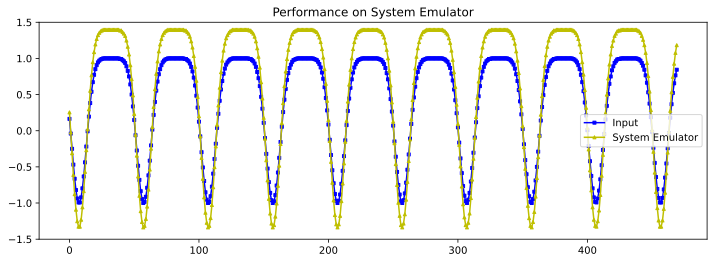

In [43]:
# Minimal design

WihXibih_min = np.zeros((num_hidden,),dtype=np.float32)    # Xi
WhhHibhh_min_prev = np.zeros((num_hidden,),dtype=np.float32)    # Hi
WhhHibhh_min = np.zeros((num_hidden,),dtype=np.float32)    # Hi
WhhHibhh_min_t = np.zeros((num_hidden,),dtype=np.float32)    # Hi
Hi_min_t = np.zeros((num_hidden,),dtype=np.float32)
Ho_min_t = np.zeros((num_hidden,),dtype=np.float32)          # Ho = tahn(WhhHibhh)
Ho_min = np.zeros((num_hidden,),dtype=np.float32)
YHAT_min = np.zeros((1,),dtype=np.float32)                  # Prediction
YHAT_min_result = np.zeros(N)

for timei in range(N):
  data_test_in_min = data_fixed_16[timei]
  for i in range(num_hidden):
      WihXibih_min[i] = Wih_fixed[i,0]*data_test_in_min/precision + bih_fixed[i]

  for i in range(num_hidden):
    if timei == 0:
      WhhHibhh_min[i] = bhh_fixed[i]
    else:
      WhhHibhh_min_t[i] = (Whh_fixed[i,0]*WhhHibhh_min_prev[0] + Whh_fixed[i,1]*WhhHibhh_min_prev[1] + Whh_fixed[i,2]*WhhHibhh_min_prev[2] + \
                        Whh_fixed[i,3]*WhhHibhh_min_prev[3] + Whh_fixed[i,4]*WhhHibhh_min_prev[4] + Whh_fixed[i,5]*WhhHibhh_min_prev[5] + \
                        Whh_fixed[i,6]*WhhHibhh_min_prev[6] + Whh_fixed[i,7]*WhhHibhh_min_prev[7] + Whh_fixed[i,8]*WhhHibhh_min_prev[8])/precision
      WhhHibhh_min[i] = WhhHibhh_min_t[i] + bhh_fixed[i]
    WhhHibhh_min_prev[i] = WhhHibhh_min[i]

  for i in range(num_hidden):
    Hi_min_t[i] = (WhhHibhh_min[i] + WihXibih_min[i])
    Ho_min[i] = tanh_func((WhhHibhh_min[i] + WihXibih_min[i])/np.float32(precision)) * np.float32(precision)
#    Ho_min[i] = np.tanh((WhhHibhh_min[i] + WihXibih_min[i])/np.float32(precision)) * np.float32(precision)

  YHAT_min = (Who_fixed[0,0]*Ho_min[0] + Who_fixed[0,1]*Ho_min[1] + Who_fixed[0,2]*Ho_min[2] + Who_fixed[0,3]*Ho_min[3] + Who_fixed[0,4]*Ho_min[4] + \
                Who_fixed[0,5]*Ho_min[5] + Who_fixed[0,6]*Ho_min[6] + Who_fixed[0,7]*Ho_min[7] + Who_fixed[0,8]*Ho_min[8])/np.float32(precision) + bho_fixed[0]

  YHAT_min_result[timei] = YHAT_min

# plotting
fig = plt.figure(figsize=(12,4))
plt.plot(np.multiply(data_fixed_16[30:],1/precision),'bs-',label='Input',markersize=3)
plt.plot(np.multiply(YHAT_min_result[30:],1/precision),'y^-',label='System Emulator',markersize=3)
plt.ylim([-1.5,1.5])
#plt.xlim([100,200])
plt.legend()
plt.title('Performance on System Emulator')
plt.show()

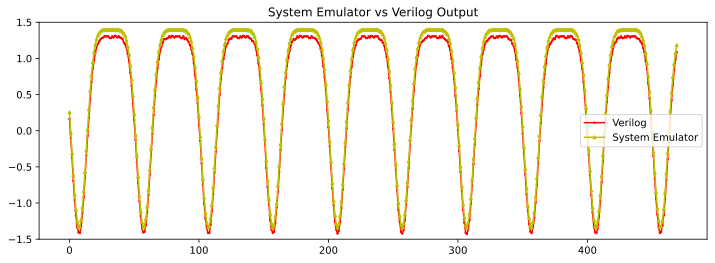

In [49]:
from pandas import read_csv
df = read_csv('/content/drive/MyDrive/Colab Notebooks/yhat_verilog_sc.csv') #*** MODIFY the path for you local drive****#
data_verilog = df.values

# plotting
fig = plt.figure(figsize=(12,4))
plt.plot(np.multiply(data_verilog[29:],1/128),'r.-',markerfacecolor='r', label='Verilog',markersize=3) # 1 Sample shifted for the hardware structure
plt.plot(np.multiply(YHAT_min_result[30:],1/precision),'y^-',label='System Emulator',markersize=3)
plt.ylim([-1.5,1.5])
#plt.xlim([100,200])
plt.legend()
plt.title('System Emulator vs Verilog Output')
plt.show()

In [ ]:
""" 
#For tanh approximation

a = np.arange(-4,+4,0.1)
b = np.tanh(a)
print(b)
# plotting
fig = plt.figure(figsize=(12,4))
plt.plot(b,'r*-',label='Actual data',markersize=3)
plt.ylim([-1.5,1.5])
#plt.xlim([60,68])
plt.legend()
plt.title('TANH approximation')
plt.show()

"""

In [ ]:
#sys.stdout.close()